## Ensemble Learning Model to Predict Credit Card Fraud

### Dataset from Kaggle contains 284,807 examples with 31 features.

##### Import Pandas, Numpy, Matplotlib, and various Scitkit Learn libraries

In [292]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics as metrics
from scipy.stats import skew

##### Load Dataset from csv file

In [293]:
CREDIT_FRAUD_PATH = os.path.join("dataset", "creditcardfraud")

if not os.path.isdir(CREDIT_FRAUD_PATH):
    os.makedirs(CREDIT_FRAUD_PATH)

def load_credit_fraud_data(credit_fraud_path=CREDIT_FRAUD_PATH):
    csv_path = os.path.join(credit_fraud_path, "creditcard.csv")
    
    return pd.read_csv(csv_path, float_precision='round_trip')

credit_fraud = load_credit_fraud_data()

##### Visualize the Data

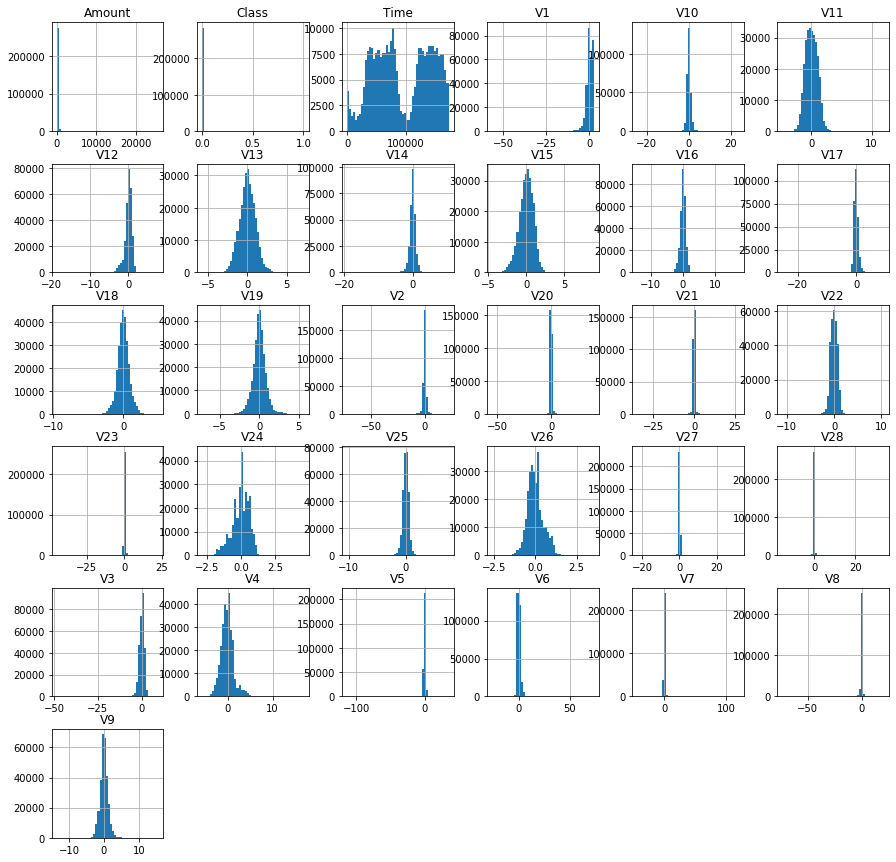

In [294]:
credit_fraud.hist(bins=50, figsize=(15,15))

##### Create a train and test set. These sets may contain null values because we haven't pre-processed them yet. 
##### Because the dataset has enough training examples, we will use a 75 / 25 train test split.

In [295]:
# Add an index column to the dataset.
credit_fraud_with_id = credit_fraud.reset_index()

train_set, test_set = train_test_split(credit_fraud_with_id, train_size=0.75, random_state=42, shuffle=True)
credit_train = train_set.copy()
credit_test = test_set.copy()

##### Pre-process methods

In [296]:
def impute_median(data):
    """Imputation transformer for completing missing numerical values."""
    if isinstance(data, pd.DataFrame):
        imputer = SimpleImputer(strategy="median")
        imputer.fit(data)
        X = imputer.transform(data)
        return pd.DataFrame(X, columns=data.columns, index=data.index)
    else:
        # not a DataFrame
        return None
    
def drop_missing_values(data):
    """Drops data if there are less than 17 non-NA values in the row"""
    if isinstance(data, pd.DataFrame):
        # The row must contain at least 17 non-NA values to stay in the dataset.
        data.dropna(how="any", axis=0, thresh=17)
        return data.fillna("", inplace=False)
    else:
        # not a DataFrame
        return None
    
def log_transform(data):
    """Log Transformation for left skewed data"""
    if isinstance(data, pd.Series):
        # Check skew value. If outside of -1 to 1 range, do the log transform
        skew_value = skew(data)
        if (abs(skew_value) > 1):
            minimum = data.min()
            data_copy = data.copy()

            # Shift right to ensure all positive values
            data_copy += (-1 * minimum) + 2

            # Execute log Transform
            transformed_data = data_copy.transform(np.log)

            # Shift back left
            transformed_data += minimum - 2
            return transformed_data
        else:
            # Not skewed enough to worry about
            return data
    else:
        # not a DataFrame
        return data

##### Execute Pre-processing

In [297]:
credit_transformed = credit_fraud_with_id.copy()
features_to_transform = ["V24", "V26"]
for i in range(len(features_to_transform)):
    feature = features_to_transform[i]
    credit_transformed[feature] = log_transform(credit_transformed[feature])
    
credit_dropped = drop_missing_values(credit_transformed)
credit_fraud_imputed = impute_median(credit_fraud_with_id)

##### Stratify data

In [298]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

#credit_dropped["time_attribute"] = pd.cut(credit_dropped["Time"], 
#                                       bins=[0., 35000, 70000, 105000, 140000, 175000., np.inf],
#                                       labels=[1, 2, 3, 4, 5, 6])

### Figure out scikitlearn issue here.
#for train_index, test_index in strat_split.split(credit_dropped, credit_dropped["time_attribute"]):
#    print(train_index)
#    print(test_index)
#    strat_train_set = credit_dropped.loc[train_index]
#    strat_test_set = credit_dropped.loc[test_index]

##### Visualize the data to gain insights

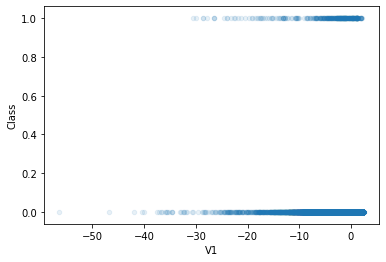

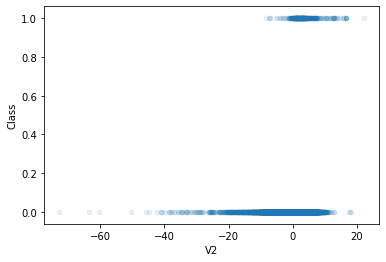

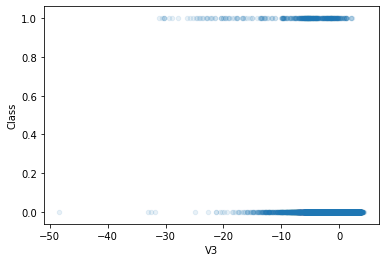

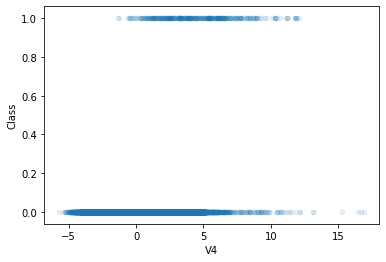

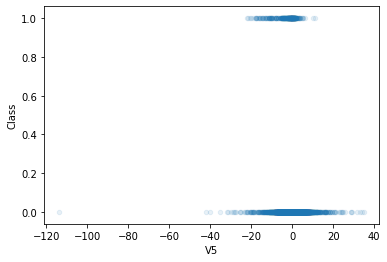

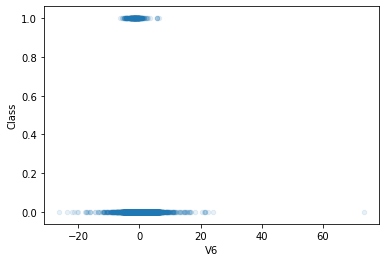

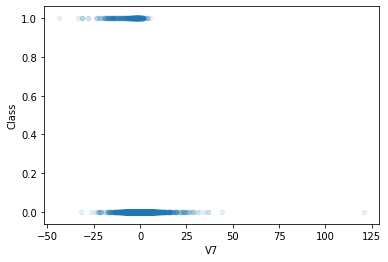

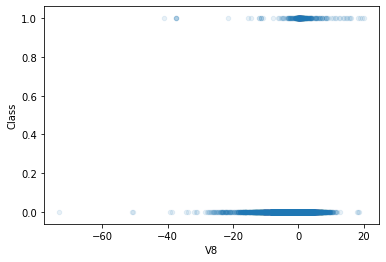

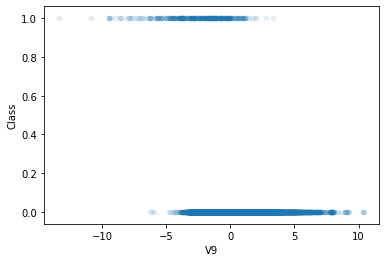

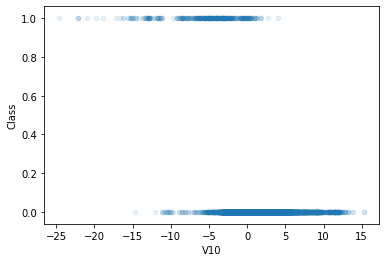

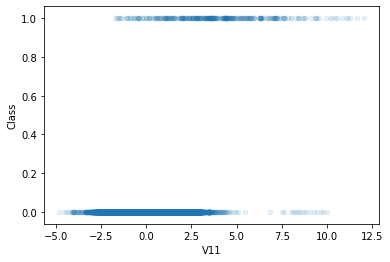

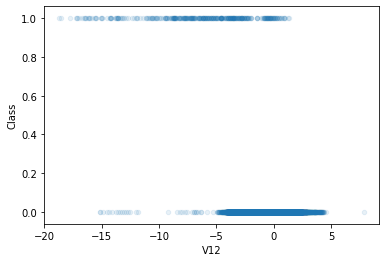

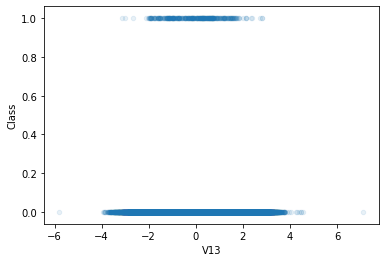

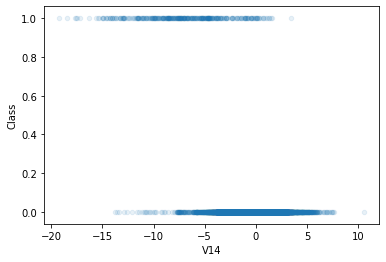

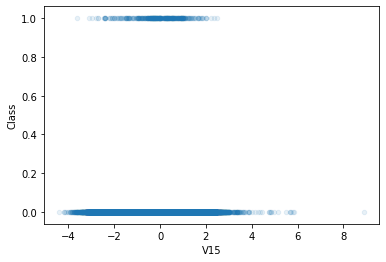

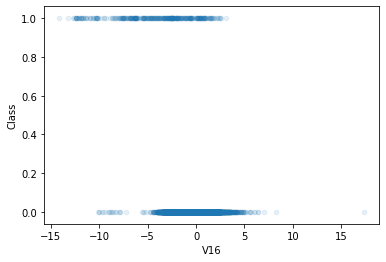

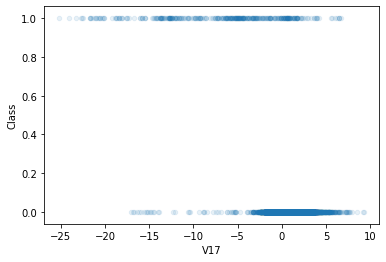

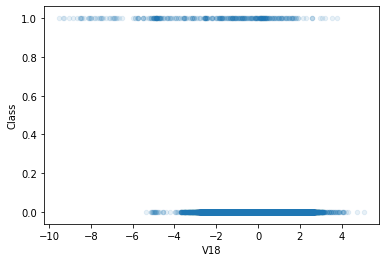

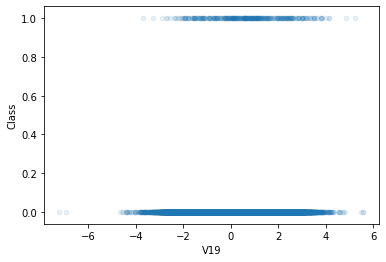

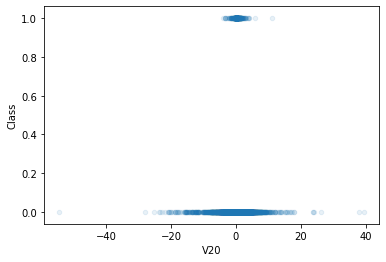

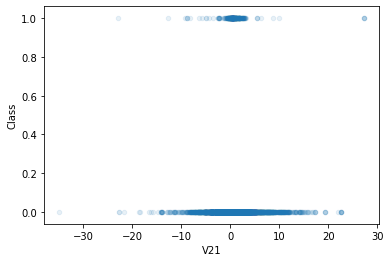

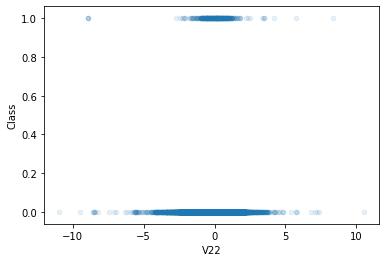

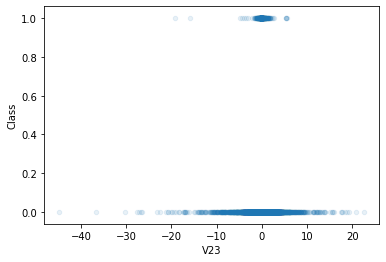

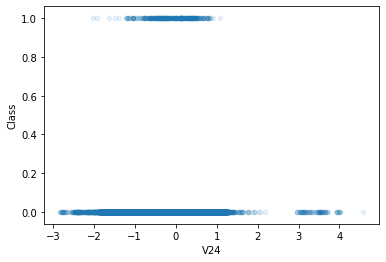

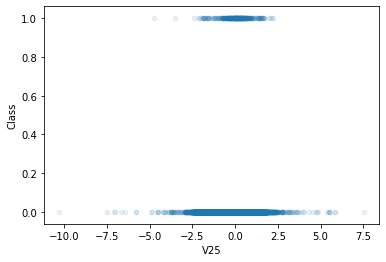

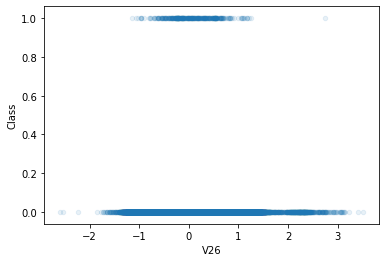

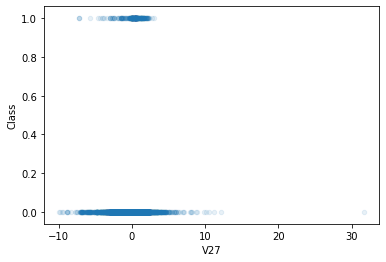

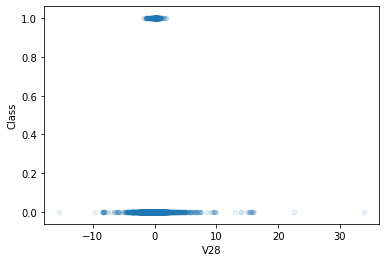

In [299]:
for i in range(28):
    feature = "V" + str(i + 1)
    credit_train.plot(kind="scatter", x=feature, y="Class", alpha="0.1")

### Look at data correlations
##### Correlation coefficient ranges from -1 to 1. When it is close to one, it means there is a string positive correlation. 
##### Example: if there is a strong positive correlation, the Class value tends to go up when the correlated attribute goes up.
##### Example: If there is a strong negative correlation, that means the Class value tends to decrease when the correlated attribute decreases. 
##### Note that the correlation coefficient only measure linear correlations! It completely misses out on any nonlinear relationships
##### We find that there aren't any strong correlations between the Class attribute and any of the features. V17 has the largest negative correlation at -0.324 and feature V11 has the largest positive correlation at 0.15.

In [300]:
corr_matrix = credit_train.corr()

##### Another way to check for correlations between attributes is to use pandas scatter_matrix() function which plots every numerical attribute against every other numerical attribute. Since there are 32 numerical attributes, we would get 32 * 32 = 1024 plots.
##### Try out a few classes below

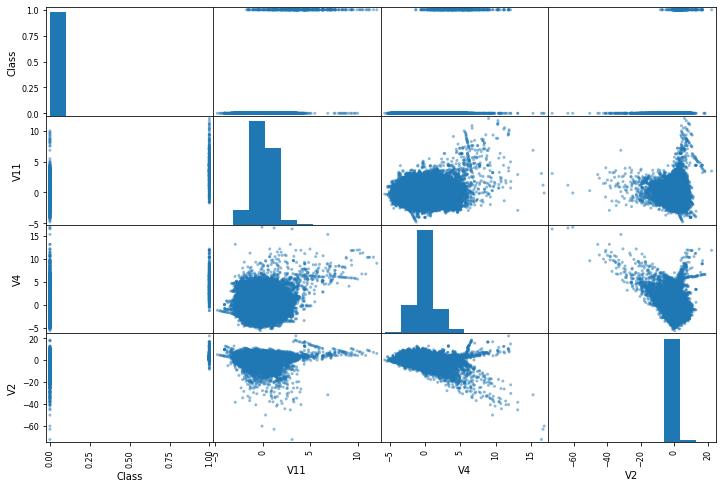

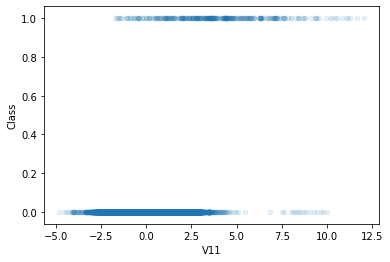

In [301]:
attributes = ["Class", "V11", "V4", "V2"]
matrix = scatter_matrix(credit_train[attributes], figsize=(12,8))
credit_train.plot(kind="scatter", x="V11", y="Class", alpha=0.1)

#### Drop label feature ('Class'), index, and time feature. 
##### The time feature is being dropped because it doesn't add any value. This was added for a metric to know when the transactions occured after each other (NOT the time of day it occured).

In [302]:
to_drop = ["Class", "index", "Time"]
credit_train_X = credit_train.drop(to_drop, axis=1)
credit_train_Y = credit_train["Class"].copy()

credit_test_X = credit_test.drop(to_drop, axis=1)
credit_test_Y = credit_test["Class"].copy()

#### Train a Random Forest with different number of trees to see accuracy results
##### ** Note ** for loop is in range 1 for faster testing

In [303]:
number_of_trees = [50, 250, 500, 750]
classifiers = []

for i in range(1):
    num_estimators = number_of_trees[i]
    rnd_forest_clf = RandomForestClassifier(n_estimators=num_estimators, n_jobs=-1, oob_score=True)
    
    # Train the random forest
    rnd_forest_clf.fit(credit_train_X, credit_train_Y)
    
    # Make predictions
    y_pred = rnd_forest_clf.predict(credit_test_X)
    
    # Generate Scores
    score = accuracy_score(credit_test_Y, y_pred)
    classifiers.append(rnd_forest_clf)
    misclassified = credit_test_Y[y_pred != credit_test_Y]
    num_test_instances = y_pred.shape[0]
    num_misclassified = misclassified.shape[0]

#### Gather results from training and testing

In [304]:
recall_score = recall_score(credit_test_Y, y_pred)
precision_score = precision_score(credit_test_Y, y_pred)
confusion_matrix = confusion_matrix(credit_test_Y, y_pred)
accuracy_score = accuracy_score(credit_test_Y, y_pred)
f1_score = f1_score(credit_test_Y, y_pred)
probabilites = rnd_forest_clf.predict_proba(credit_test_X)
predictions = probabilites[:,1]
fpr, tpr, threshold = metrics.roc_curve(credit_test_Y, predictions)
roc_auc = metrics.auc(fpr, tpr)

#### Analyze and visualize the results
##### Plot the ROC Area Under Curve Score, then display the F1 score, a confusion matrix, accuracy score, the OOB score, and finally the model accuracy.
##### ** Note ** With classification models, it is important to use testing methods other than accuracy to determine how good your model is predicting.

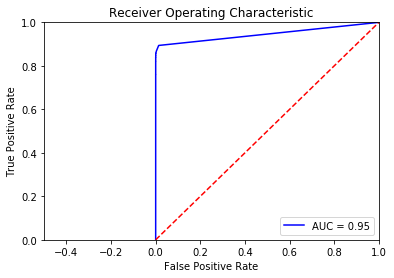

F1 Score: 0.8653846153846154
Confusion Matrix
[[71084     5]
 [   23    90]]
Accuracy Score 0.9996067526193084
Number of test instances: 71202
Number of misclassified instances: 28
Model Accuracy 0.9996067526193084
OOB Score:  0.9995037569345286


In [309]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.5, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

print("F1 Score:", f1_score)
print("Confusion Matrix")
print(confusion_matrix)
print("Accuracy Score", accuracy_score)
print("Number of test instances:", num_test_instances)
print("Number of misclassified instances:", num_misclassified)
print("Model Accuracy", ( (num_test_instances - num_misclassified) / num_test_instances))

for y in range(len(classifiers)):
    print("OOB Score: ", classifiers[y].oob_score_)